# milner lab redo

In [1]:
# Import all the things.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import json

In [2]:
# Config
SAVE_FIGS = False
SQRT_NUM_OF_TRIALS = np.sqrt(10)

## Helper funcs

In [3]:
def get_crests(df, use_troughs=False):
    points = df['Recording (a.u.)'].tolist() # Store a list of the points from the sample.
    crests = []
    ends_of_cycles = []

    for index, point in enumerate(points): # Go through each point one by one
        try:
            if point > 0 and points[index+1] < 0:
                ends_of_cycles.append(index)
        except IndexError:
            pass


    cycles = [sl.tolist() for sl in np.split(points, ends_of_cycles)][:-1]
    for cycle in cycles:
        crests.append(max(cycle) if use_troughs is False else min(cycle))
    return crests

In [4]:
def less_lossy_avg_period(df, crests):
    first_crest_row = df.loc[df['Recording (a.u.)'] == crests[0]]
    first_crest_time = first_crest_row['Time (ms)'].values[0]

    last_crest_row = df.loc[df['Recording (a.u.)'] == crests[-1]]
    last_crest_time = last_crest_row['Time (ms)'].values[0]

    alt_total = (last_crest_time - first_crest_time) / (len(crests) - 1) / 1000
    return alt_total

In [5]:
def freq_from_period(p):
    return 1 / p

In [6]:
def lint_crests(samplename, c):
    MODS_TABLE = {
        'cuecard-t1': (x for x in c if x < -0.025),
        'cuecard-t3': (x for x in c if x < -0.05),
        'cuecard-t6': (x for x in c if x < -0.01),
        'cuecard-t8': (x for x in c if x < -0.0065),
        'cuecard-t10': (x for x in c if x < -0.003),
        'hexkey-t1': (x for x in c if x > 0.01),
        'hexkey-t4': (x for x in c if x > 0.02),
        'hexkey-t7': (x for x in c if x > 0.05),
        'hexkey-t10': (x for x in c if x > 0.1),
        'ruler-t2': (x for x in c if x > 0.07),
        'ruler-t4': (x for x in c if x > 0.05),
        'ruler-t5': (x for x in c if x > 0.05),
        'ruler-t6': (x for x in c if x > 0.05),
        'ruler-t7': (x for x in c if x > 0.015),
        'ruler-t8': (x for x in chain([0.11386307328939438], [None] * 18, [0.07866601645946503])),
        'ruler-t9': (x for x in c if x > 0.05),
        'eraser-t1': (x for idx, x in enumerate(c) if idx not in [5, 7]),
        'eraser-t3': (x for x in c if x > 0.016033241525292397),
        'unknown-t1': (x for x in c if x > 0.02),
        'unknown-t2': (x for x in c if x > 0.01),
        'unknown-t4': (x for x in c if x > 0.025),
    }
    try:
        return list(MODS_TABLE[samplename])
    except KeyError:
        return c

In [7]:
# Getting the frequencies using average periods for each wave:

def get_all_freqs(smpl, use_troughs=False):
    freqs = {}

    for item in smpl.keys():
        fr = smpl[item]
        c = get_crests(fr, use_troughs=use_troughs)
        print(f'# of crests before linting for {item}:', len(c))
        c = lint_crests(item, c)
        print(f'# of crests after linting for {item}:', len(c))
        p = less_lossy_avg_period(fr, c)
        print(f'Avg period of {item}: {p}')
        f = freq_from_period(p)
        print(f'Frequency of {item}: {f}')
        freqs[item] = f
        print('---')

    return freqs

In [8]:
def big_scary_plot(smpls):
    fig = plt.figure(figsize=[12,6])

    for frame in smpls.keys():
        fr = smpls[frame]
        plt.plot(fr['Time (ms)'], fr['Recording (a.u.)'])

    plt.legend(smpls.keys())
    plt.grid(visible=True)
    plt.show()

In [9]:
def plot_freqs(freqs, samples, material="", ylim_b=380, ylim_t=400, bestfit=False):
    fig = plt.figure(figsize=[12,6])
    
    item_freqlist = list(freqs.values())

    stdev_of_set = np.std(item_freqlist)
    
    for item in freqs.keys():
        plt.bar(item, freqs[item], yerr=stdev_of_set, capsize=4)
    
    # styling
    plt.legend(samples.keys())


    if bestfit:
        # plots a best fit line. dark magic, idk how this works.
        # https://www.delftstack.com/howto/matplotlib/plot-numpy-linear-fit-matplotlib-python/
        linear_model = np.polyfit([0,1,2,3,4], item_freqlist, 2)
        linear_model_fn = np.poly1d(linear_model)
        x_s = np.arange(0,5)
        plt.plot(x_s, linear_model_fn(x_s), color="red", linewidth=3)
    else:
        plt.axhline(np.average(item_freqlist), color='red', linestyle='solid', linewidth=3)
    
    plt.grid(visible=True)
    plt.ylim(ylim_b, ylim_t)
    plt.title(f'Frequency of each {material} trial')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Trial #')

    # display
    plt.show()
    fig.savefig(f'assets/{material}.png') if SAVE_FIGS else None

In [10]:
def plot_trial_dataframe(df, name=None):
    df.plot(
        x='Time (ms)',
        y='Recording (a.u.)',
        figsize=(12,6),
        grid=True,
        title=name,
        xlabel='Time (ms)',
        ylabel='Amplitude'
    )

In [11]:
def sem_of_dataset(freqs):
    stdev = np.std(freqs)
    sem = stdev / SQRT_NUM_OF_TRIALS
    return sem

## cuecard

In [12]:
cuecard_t1 = pd.read_excel('cuecard-t1.xls')
cuecard_t2 = pd.read_excel('cuecard-t2.xls')
cuecard_t3 = pd.read_excel('cuecard-t3.xls')
cuecard_t4 = pd.read_excel('cuecard-t4.xls')
cuecard_t5 = pd.read_excel('cuecard-t5.xls')
cuecard_t6 = pd.read_excel('cuecard-t6.xls')
cuecard_t7 = pd.read_excel('cuecard-t7.xls')
cuecard_t8 = pd.read_excel('cuecard-t8.xls')
cuecard_t9 = pd.read_excel('cuecard-t9.xls')
cuecard_t10 = pd.read_excel('cuecard-t10.xls')

In [13]:
CUECARD_SAMPLES = {
    'cuecard-t1': cuecard_t1,
    'cuecard-t2': cuecard_t2,
    'cuecard-t3': cuecard_t3,
    'cuecard-t4': cuecard_t4,
    'cuecard-t5': cuecard_t5,
    'cuecard-t6': cuecard_t6,
    'cuecard-t7': cuecard_t7,
    'cuecard-t8': cuecard_t8,
    'cuecard-t9': cuecard_t9,
    'cuecard-t10': cuecard_t10,
}

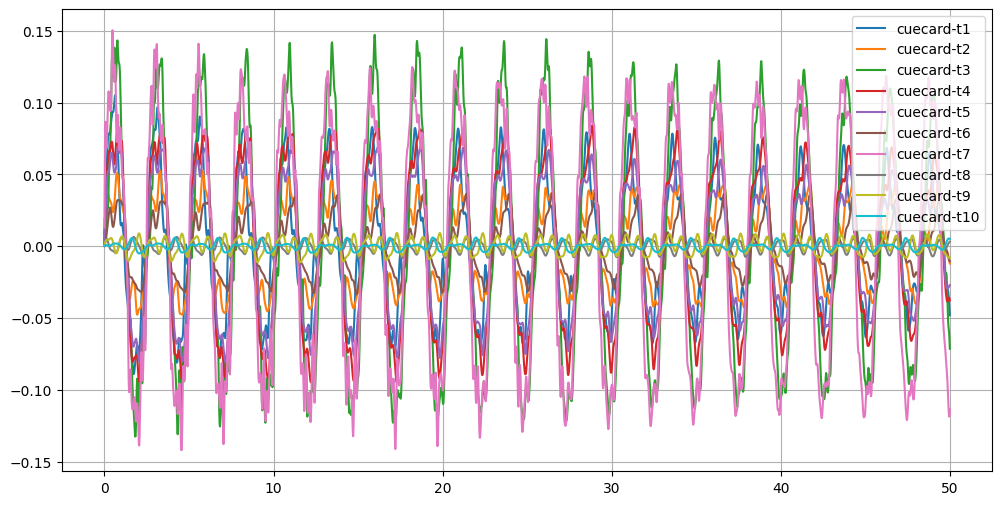

In [14]:
big_scary_plot(CUECARD_SAMPLES)

In [15]:
cuecard_freqs = get_all_freqs(CUECARD_SAMPLES, use_troughs=True)
# manually patching weird waves.
cuecard_freqs['cuecard-t9'] = 391.57
cuecard_freqs['cuecard-t8'] = 391.57
cuecard_freqs['cuecard-t7'] = 393.77
cuecard_freqs['cuecard-t4'] = 393.94
cuecard_freqs['cuecard-t5'] = 394.23
cuecard_freqs['cuecard-t2'] = 393.93
cuecard_freqs['cuecard-t6'] = 391.9060827303

# of crests before linting for cuecard-t1: 23
# of crests after linting for cuecard-t1: 19
Avg period of cuecard-t1: 0.002545235299316895
Frequency of cuecard-t1: 392.89098350489866
---
# of crests before linting for cuecard-t2: 20
# of crests after linting for cuecard-t2: 20
Avg period of cuecard-t2: 0.0025253149541150893
Frequency of cuecard-t2: 395.99021039750505
---
# of crests before linting for cuecard-t3: 21
# of crests after linting for cuecard-t3: 19
Avg period of cuecard-t3: 0.0025406054943158634
Frequency of cuecard-t3: 393.60695796231084
---
# of crests before linting for cuecard-t4: 20
# of crests after linting for cuecard-t4: 20
Avg period of cuecard-t4: 0.002511060028190862
Frequency of cuecard-t4: 398.2381897578402
---
# of crests before linting for cuecard-t5: 20
# of crests after linting for cuecard-t5: 20
Avg period of cuecard-t5: 0.0025176392247712744
Frequency of cuecard-t5: 397.19749762432673
---
# of crests before linting for cuecard-t6: 23
# of crests after lint

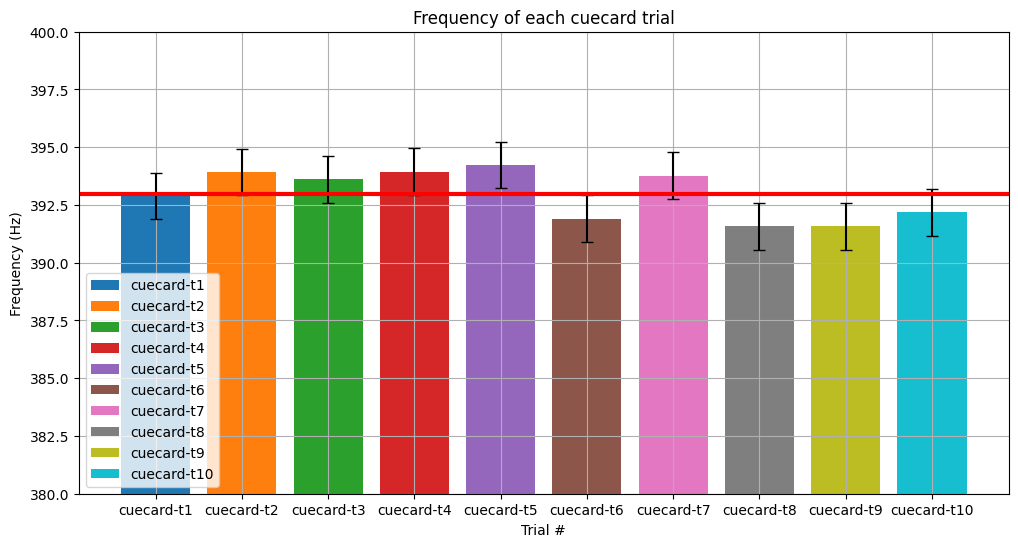

In [16]:
plot_freqs(cuecard_freqs, CUECARD_SAMPLES, material='cuecard')

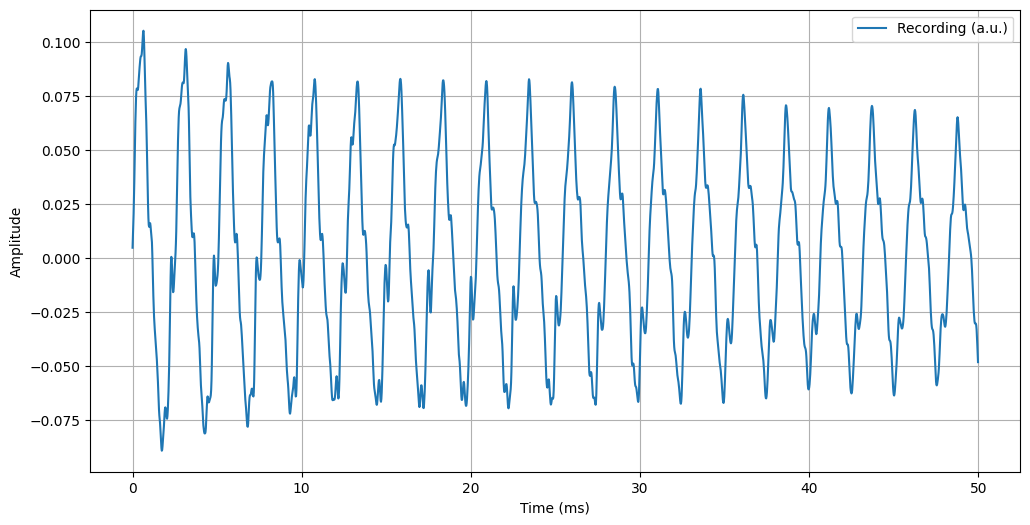

In [17]:
plot_trial_dataframe(cuecard_t1)

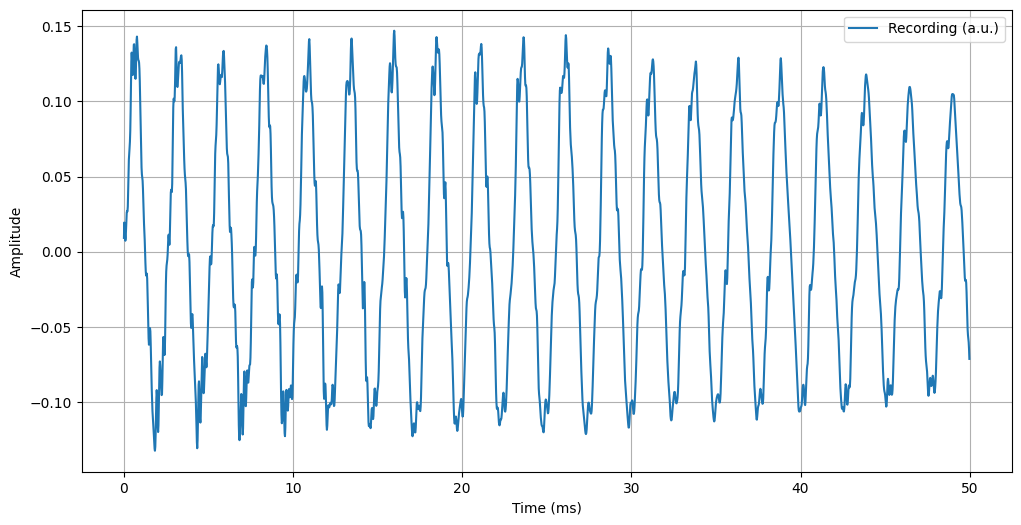

In [18]:
plot_trial_dataframe(cuecard_t3)

In [19]:
CUECARD_FREQSLIST = list(cuecard_freqs.values())
CUECARD_AVG = np.average(CUECARD_FREQSLIST)
CUECARD_AVG

392.9591633243026

## hexkey

In [20]:
hexkey_t1 = pd.read_excel('hexkey-t1.xls')
hexkey_t2 = pd.read_excel('hexkey-t2.xls')
hexkey_t3 = pd.read_excel('hexkey-t3.xls')
hexkey_t4 = pd.read_excel('hexkey-t4.xls')
hexkey_t5 = pd.read_excel('hexkey-t5.xls')
hexkey_t6 = pd.read_excel('hexkey-t6.xls')
hexkey_t7 = pd.read_excel('hexkey-t7.xls')
hexkey_t8 = pd.read_excel('hexkey-t8.xls')
hexkey_t9 = pd.read_excel('hexkey-t9.xls')
hexkey_t10 = pd.read_excel('hexkey-t10.xls')

In [21]:
HEXKEY_SAMPLES = {
    'hexkey-t1': hexkey_t1,
    'hexkey-t2': hexkey_t2,
    'hexkey-t3': hexkey_t3,
    'hexkey-t4': hexkey_t4,
    'hexkey-t5': hexkey_t5,
    'hexkey-t6': hexkey_t6,
    'hexkey-t7': hexkey_t7,
    'hexkey-t8': hexkey_t8,
    'hexkey-t9': hexkey_t9,
    'hexkey-t10': hexkey_t10,
}

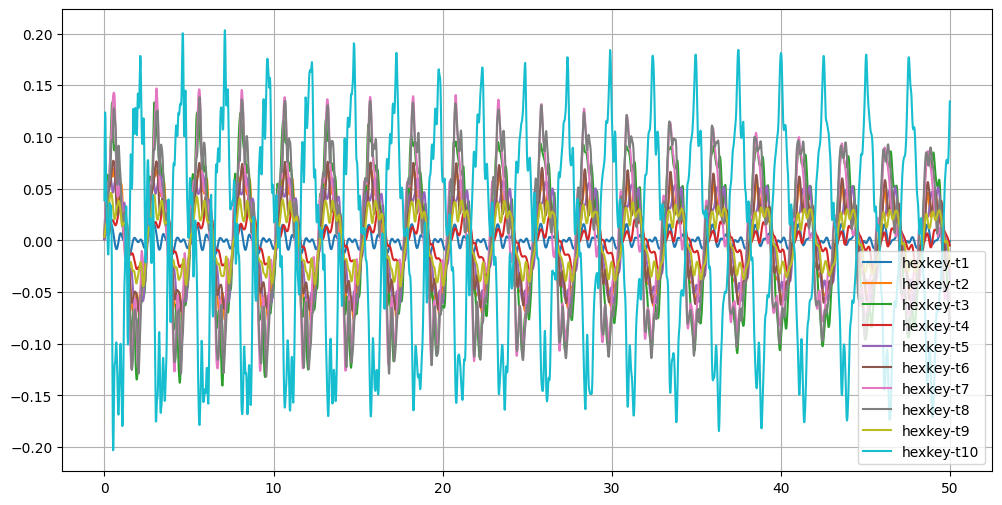

In [22]:
fig = plt.figure(figsize=[12,6])

for frame in HEXKEY_SAMPLES.keys():
    fr = HEXKEY_SAMPLES[frame]
    plt.plot(fr['Time (ms)'], fr['Recording (a.u.)'])

plt.legend(HEXKEY_SAMPLES.keys())
plt.grid(visible=True)
plt.show()

In [23]:
hexkey_freqs = get_all_freqs(HEXKEY_SAMPLES)
# manually patching weird waves.
hexkey_freqs['hexkey-t10'] = 392.24
hexkey_freqs['hexkey-t9'] = 394.28

# of crests before linting for hexkey-t1: 75
# of crests after linting for hexkey-t1: 20
Avg period of hexkey-t1: 0.0025395698800393172
Frequency of hexkey-t1: 393.7674674203169
---
# of crests before linting for hexkey-t2: 20
# of crests after linting for hexkey-t2: 20
Avg period of hexkey-t2: 0.0025538248059635447
Frequency of hexkey-t2: 391.5695382333422
---
# of crests before linting for hexkey-t3: 20
# of crests after linting for hexkey-t3: 20
Avg period of hexkey-t3: 0.0025549213387269475
Frequency of hexkey-t3: 391.40148263753383
---
# of crests before linting for hexkey-t4: 31
# of crests after linting for hexkey-t4: 20
Avg period of hexkey-t4: 0.0025505352076733386
Frequency of hexkey-t4: 392.0745720315795
---
# of crests before linting for hexkey-t5: 20
# of crests after linting for hexkey-t5: 20
Avg period of hexkey-t5: 0.002554921338726947
Frequency of hexkey-t5: 391.4014826375339
---
# of crests before linting for hexkey-t6: 20
# of crests after linting for hexkey-t6: 20
A

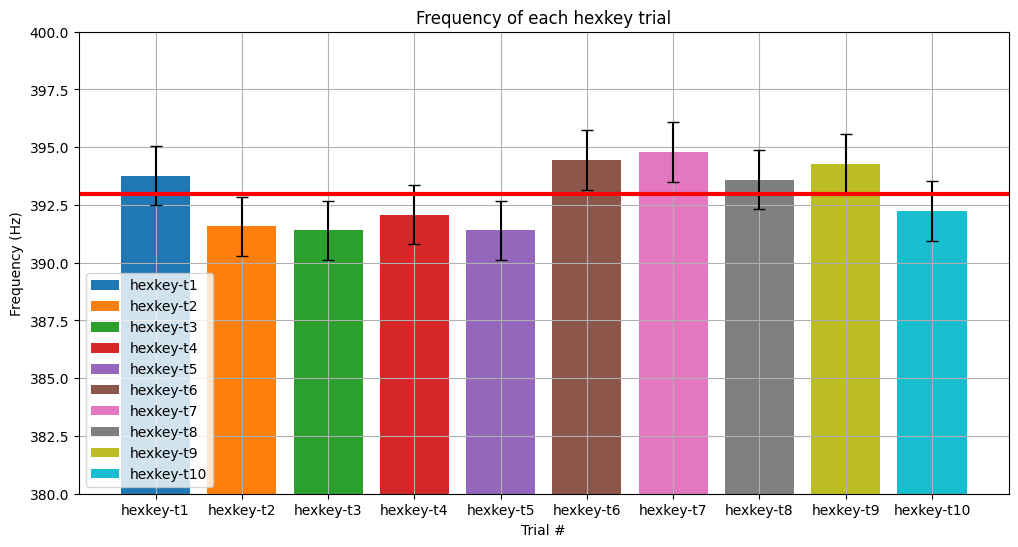

In [24]:
plot_freqs(hexkey_freqs, HEXKEY_SAMPLES, material='hexkey')

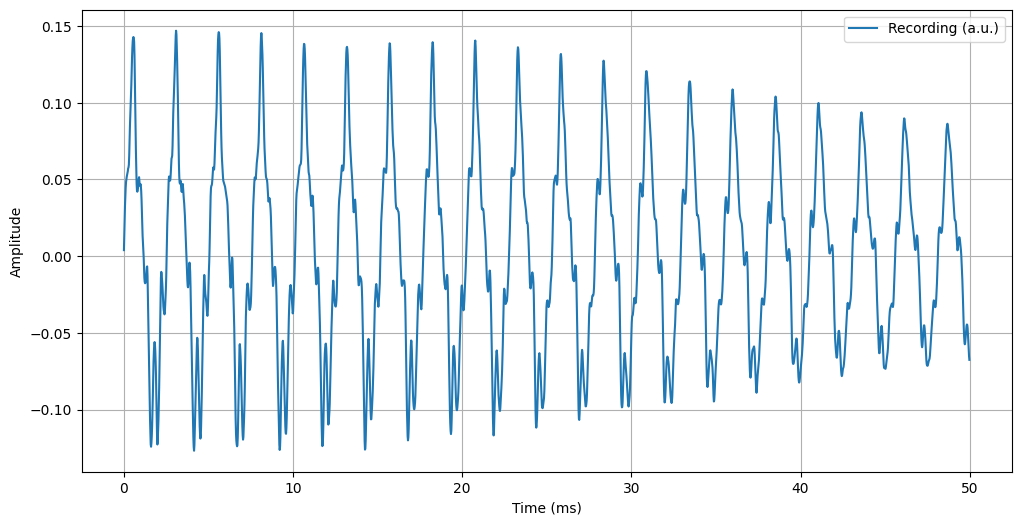

In [25]:
plot_trial_dataframe(hexkey_t7)

In [26]:
HEXKEY_FREQSLIST = list(hexkey_freqs.values())
HEXKEY_AVG = np.average(HEXKEY_FREQSLIST)
HEXKEY_AVG

392.95710293422115

## ruler

In [27]:
ruler_t1 = pd.read_excel('ruler-t1.xls')
ruler_t2 = pd.read_excel('ruler-t2.xls')
ruler_t3 = pd.read_excel('ruler-t3.xls')
ruler_t4 = pd.read_excel('ruler-t4.xls')
ruler_t5 = pd.read_excel('ruler-t5.xls')
ruler_t6 = pd.read_excel('ruler-t6.xls')
ruler_t7 = pd.read_excel('ruler-t7.xls')
ruler_t8 = pd.read_excel('ruler-t8.xls')
ruler_t9 = pd.read_excel('ruler-t9.xls')
ruler_t10 = pd.read_excel('ruler-t10.xls')

In [28]:
RULER_SAMPLES = {
    'ruler-t1': ruler_t1,
    'ruler-t2': ruler_t2,
    'ruler-t3': ruler_t3,
    'ruler-t4': ruler_t4,
    'ruler-t5': ruler_t5,
    'ruler-t6': ruler_t6,
    'ruler-t7': ruler_t7,
    'ruler-t8': ruler_t8,
    'ruler-t9': ruler_t9,
    'ruler-t10': ruler_t10,
}

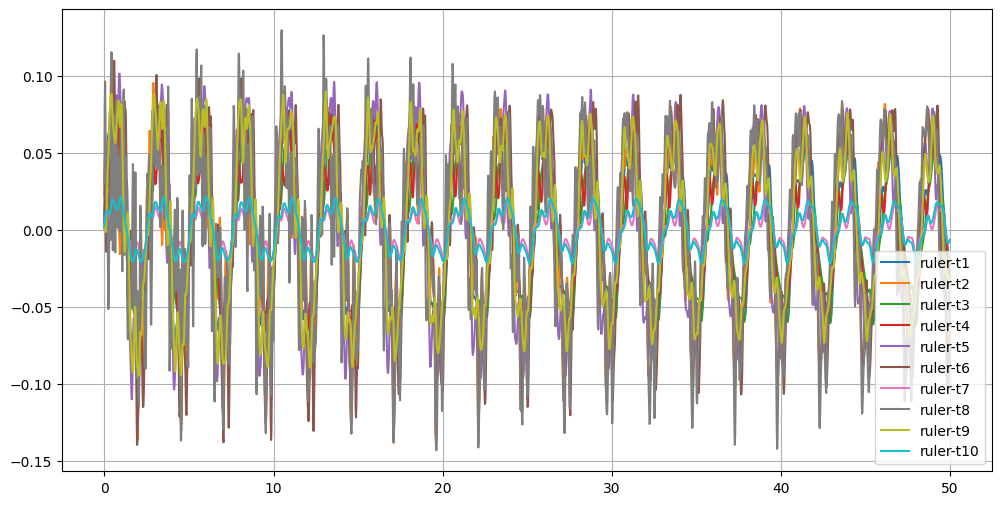

In [29]:
big_scary_plot(RULER_SAMPLES)

In [30]:
ruler_freqs = get_all_freqs(RULER_SAMPLES)

# of crests before linting for ruler-t1: 20
# of crests after linting for ruler-t1: 20
Avg period of ruler-t1: 0.0025571144042537512
Frequency of ruler-t1: 391.065803835958
---
# of crests before linting for ruler-t2: 38
# of crests after linting for ruler-t2: 20
Avg period of ruler-t2: 0.0025395698800393177
Frequency of ruler-t2: 393.76746742031685
---
# of crests before linting for ruler-t3: 20
# of crests after linting for ruler-t3: 20
Avg period of ruler-t3: 0.002559307469780556
Frequency of ruler-t3: 390.730700319389
---
# of crests before linting for ruler-t4: 22
# of crests after linting for ruler-t4: 20
Avg period of ruler-t4: 0.0025395698800393177
Frequency of ruler-t4: 393.76746742031685
---
# of crests before linting for ruler-t5: 32
# of crests after linting for ruler-t5: 20
Avg period of ruler-t5: 0.002529701085168698
Frequency of ruler-t5: 395.3036213894469
---
# of crests before linting for ruler-t6: 55
# of crests after linting for ruler-t6: 20
Avg period of ruler-t6: 0

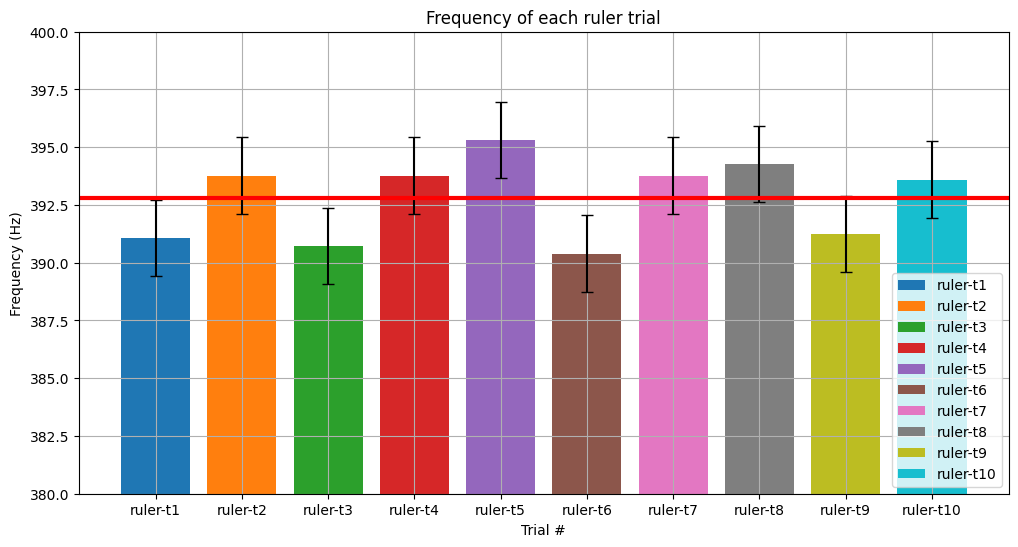

In [31]:
plot_freqs(ruler_freqs, RULER_SAMPLES, material='ruler')

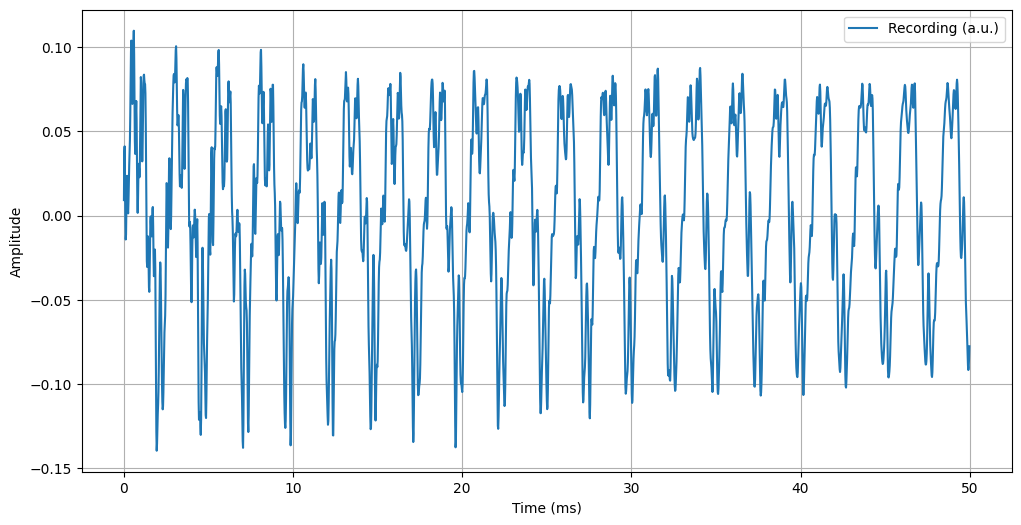

In [32]:
plot_trial_dataframe(ruler_t6)

In [33]:
RULER_FREQSLIST = list(ruler_freqs.values())
RULER_AVG = np.average(RULER_FREQSLIST)
RULER_AVG

392.79079804189564

## eraser

In [34]:
eraser_t1 = pd.read_excel('eraser-t1.xls')
eraser_t2 = pd.read_excel('eraser-t2.xls')
eraser_t3 = pd.read_excel('eraser-t3.xls')
eraser_t4 = pd.read_excel('eraser-t4.xls')
eraser_t5 = pd.read_excel('eraser-t5.xls')
eraser_t6 = pd.read_excel('eraser-t6.xls')
eraser_t7 = pd.read_excel('eraser-t7.xls')
eraser_t8 = pd.read_excel('eraser-t8.xls')
eraser_t9 = pd.read_excel('eraser-t9.xls')
eraser_t10 = pd.read_excel('eraser-t10.xls')

In [35]:
ERASER_SAMPLES = {
    'eraser-t1': eraser_t1,
    'eraser-t2': eraser_t2,
    'eraser-t3': eraser_t3,
    'eraser-t4': eraser_t4,
    'eraser-t5': eraser_t5,
    'eraser-t6': eraser_t6,
    'eraser-t7': eraser_t7,
    'eraser-t8': eraser_t8,
    'eraser-t9': eraser_t9,
    'eraser-t10': eraser_t10,
}

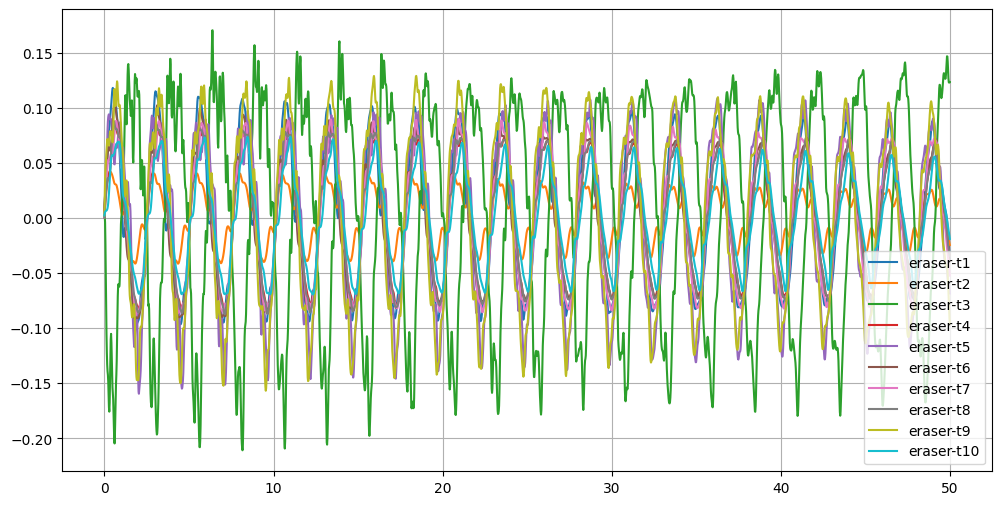

In [36]:
big_scary_plot(ERASER_SAMPLES)

In [37]:
eraser_freqs = get_all_freqs(ERASER_SAMPLES)
# manually patching weird waves.
eraser_freqs['eraser-t3'] = 396.33
eraser_freqs['eraser-t4'] = 391.74

# of crests before linting for eraser-t1: 22
# of crests after linting for eraser-t1: 20
Avg period of eraser-t1: 0.0025505352076733386
Frequency of eraser-t1: 392.0745720315795
---
# of crests before linting for eraser-t2: 20
# of crests after linting for eraser-t2: 20
Avg period of eraser-t2: 0.002556017871490349
Frequency of eraser-t2: 391.233571233571
---
# of crests before linting for eraser-t3: 27
# of crests after linting for eraser-t3: 19
Avg period of eraser-t3: 0.0025510225555681835
Frequency of eraser-t3: 391.9996700214484
---
# of crests before linting for eraser-t4: 20
# of crests after linting for eraser-t4: 20
Avg period of eraser-t4: 0.0025538248059635447
Frequency of eraser-t4: 391.5695382333422
---
# of crests before linting for eraser-t5: 20
# of crests after linting for eraser-t5: 20
Avg period of eraser-t5: 0.002564790133597566
Frequency of eraser-t5: 389.895448715457
---
# of crests before linting for eraser-t6: 20
# of crests after linting for eraser-t6: 20
Avg p

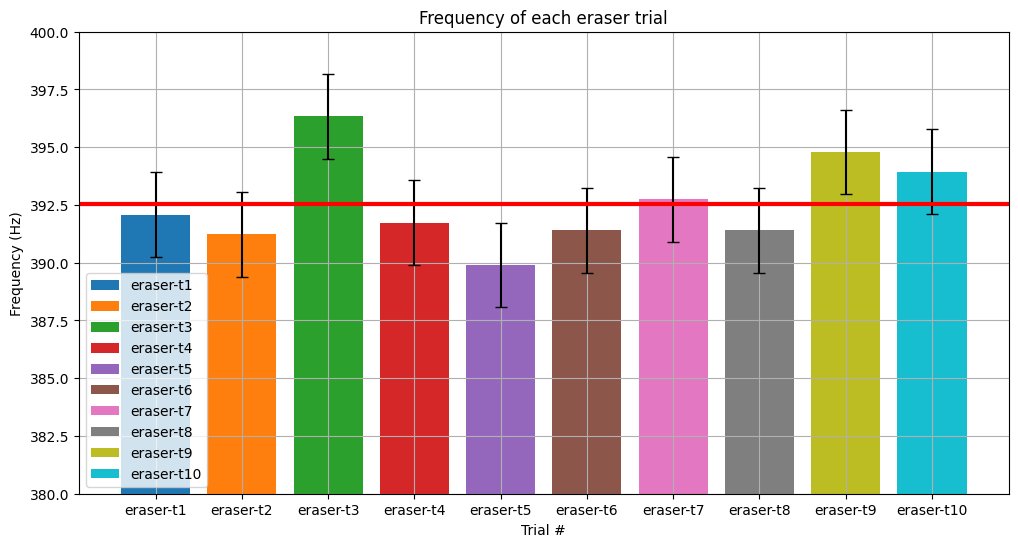

In [38]:
plot_freqs(eraser_freqs, ERASER_SAMPLES, material='eraser')

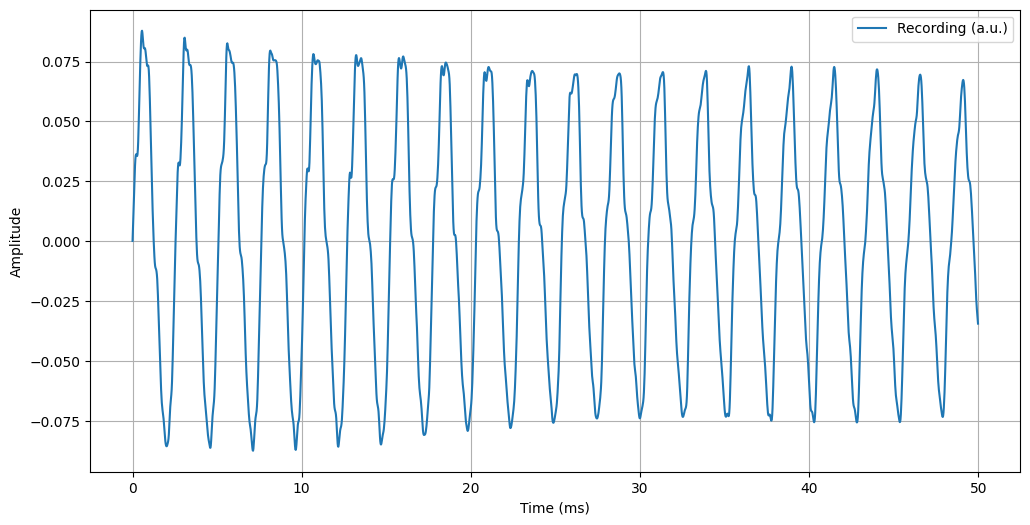

In [39]:
plot_trial_dataframe(eraser_t8)

In [40]:
ERASER_FREQSLIST = list(eraser_freqs.values())
ERASER_AVG = np.average(ERASER_FREQSLIST)
ERASER_AVG

392.5554339101768

## totals

In [41]:
ALL_FREQ_SETS = {
    'Cue card': CUECARD_FREQSLIST,
    'Hex key': HEXKEY_FREQSLIST,
    'Ruler': RULER_FREQSLIST,
    'Eraser': ERASER_FREQSLIST
}

ALL_AVGS = {
    'Cue card': CUECARD_AVG,
    'Hex key': HEXKEY_AVG,
    'Ruler': RULER_AVG,
    'Eraser': ERASER_AVG
}

AVG_VALS = np.average(list(ALL_AVGS.values()))
print(json.dumps(ALL_AVGS, indent=4))
val = ALL_AVGS['Cue card'] - ALL_AVGS['Eraser']
print('firstminuslast:', val)

{
    "Cue card": 392.9591633243026,
    "Hex key": 392.95710293422115,
    "Ruler": 392.79079804189564,
    "Eraser": 392.5554339101768
}
firstminuslast: 0.40372941412579166


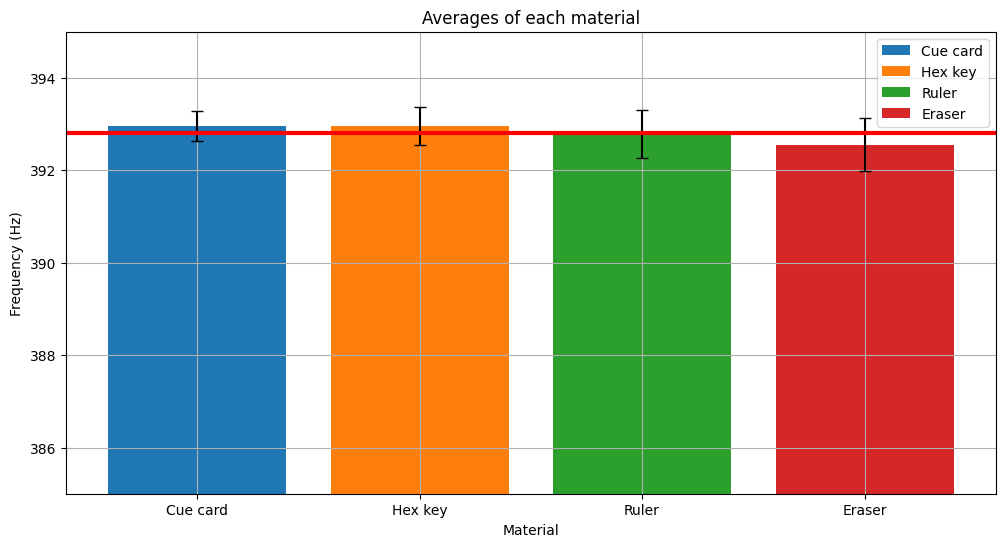

In [42]:
fig = plt.figure(figsize=[12,6])

for item in ALL_FREQ_SETS.keys():
    current_freqlist = ALL_FREQ_SETS[item]
    current_sem = sem_of_dataset(current_freqlist)
    plt.bar(item, ALL_AVGS[item], yerr=current_sem, capsize=4)

plt.legend(ALL_AVGS.keys())
plt.grid(visible=True)

# add avg line
plt.axhline(AVG_VALS, color='red', linestyle='solid', linewidth=3)
plt.title('Averages of each material')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Material')

# display
plt.ylim(385, 395)
fig.savefig('assets/all-avgs.png') if SAVE_FIGS else None
plt.show()

## uncertainty

Given that uncertainty is
$$
\frac{0.02}{N}
$$
where $N$ is the number of periods, and each wave has 20 periods, we can calculate uncertainty to be:

In [43]:
0.02 / 20

0.001

## control testing

In [44]:
control_t1 = pd.read_excel('control-t1.xls')
control_t2 = pd.read_excel('control-t2.xls')
control_t3 = pd.read_excel('control-t3.xls')
control_t4 = pd.read_excel('control-t4.xls')
control_t5 = pd.read_excel('control-t5.xls')

In [45]:
CONTROL_SAMPLES = {
    'control-t1': control_t1,
    'control-t2': control_t2,
    'control-t3': control_t3,
    'control-t4': control_t4,
    'control-t5': control_t5
}

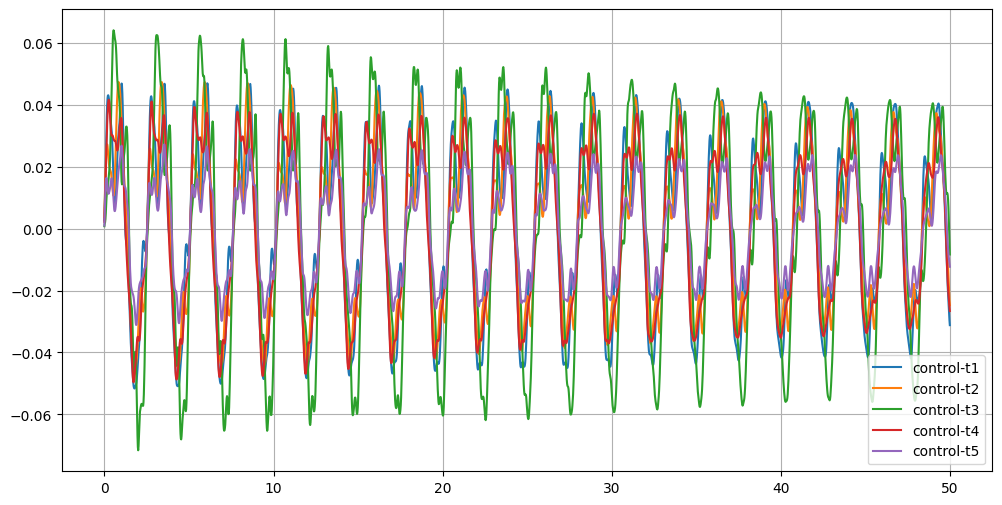

In [46]:
big_scary_plot(CONTROL_SAMPLES)

In [47]:
control_freqs = get_all_freqs(CONTROL_SAMPLES)
control_freqs['control-t4'] = 391.90608
control_freqs['control-t5'] = 391.60

# of crests before linting for control-t1: 20
# of crests after linting for control-t1: 20
Avg period of control-t1: 0.002541762945566122
Frequency of control-t1: 393.42771982116216
---
# of crests before linting for control-t2: 20
# of crests after linting for control-t2: 20
Avg period of control-t2: 0.002545052543856328
Frequency of control-t2: 392.91919627119944
---
# of crests before linting for control-t3: 20
# of crests after linting for control-t3: 20
Avg period of control-t3: 0.0025494386749099363
Frequency of control-t3: 392.24320625610926
---
# of crests before linting for control-t4: 20
# of crests after linting for control-t4: 20
Avg period of control-t4: 0.0025812381250485982
Frequency of control-t4: 387.4109832393602
---
# of crests before linting for control-t5: 20
# of crests after linting for control-t5: 20
Avg period of control-t5: 0.002549438674909937
Frequency of control-t5: 392.2432062561091
---


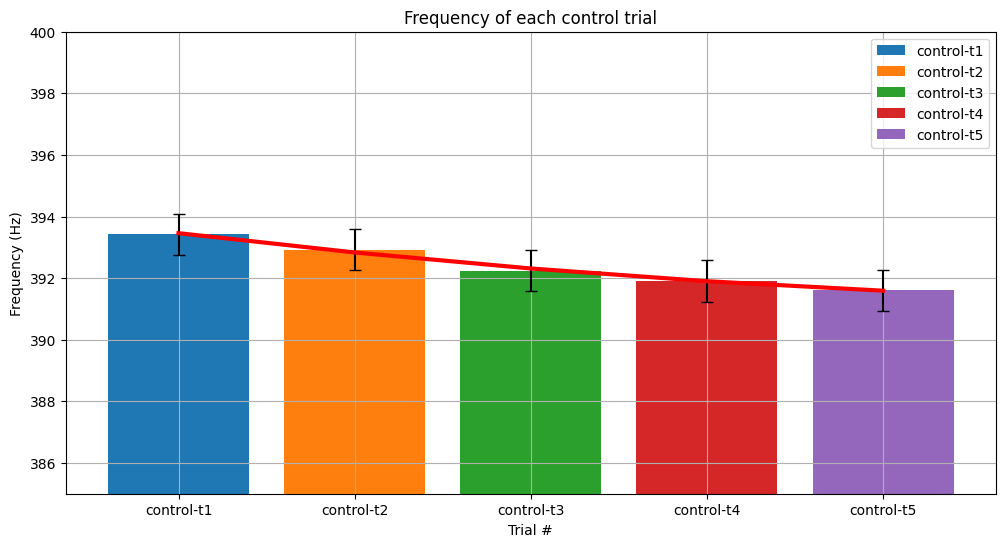

In [48]:
plot_freqs(control_freqs, CONTROL_SAMPLES, material='control', bestfit=True, ylim_b=385, ylim_t=400)

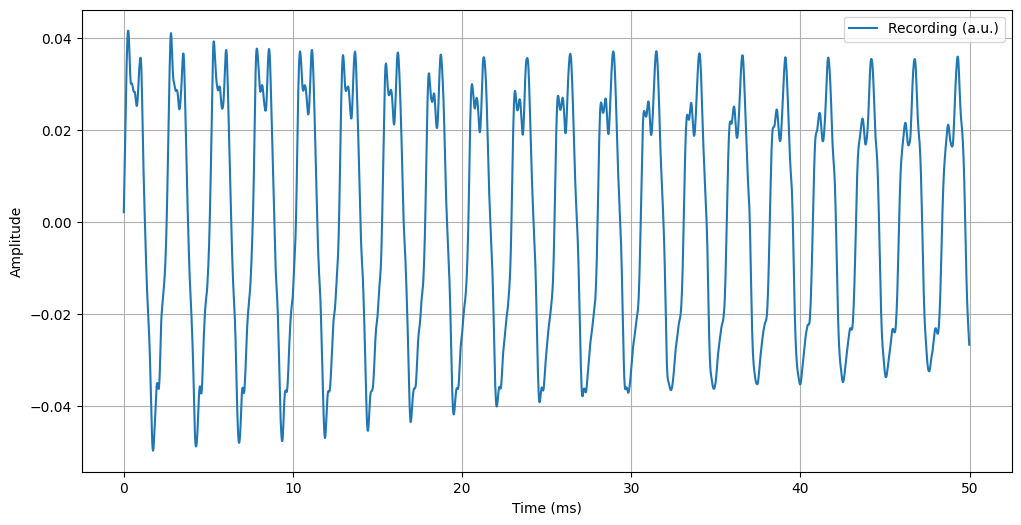

In [49]:
plot_trial_dataframe(control_t4)

In [50]:
CONTROL_FREQSLIST = list(control_freqs.values())
val = CONTROL_FREQSLIST[0] - CONTROL_FREQSLIST[-1]
print('firstminuslast:', val)
CONTROL_AVG = np.average(CONTROL_FREQSLIST)
CONTROL_AVG

firstminuslast: 1.827719821162134


392.41924046969416

## unknown

In [51]:
unknown_t1 = pd.read_excel('unknown-t1.xls')
unknown_t2 = pd.read_excel('unknown-t2.xls')
unknown_t3 = pd.read_excel('unknown-t3.xls')
unknown_t4 = pd.read_excel('unknown-t4.xls')

In [52]:
UNKNOWN_SAMPLES = {
    'unknown-t1': unknown_t1,
    'unknown-t2': unknown_t2,
    'unknown-t3': unknown_t3,
    'unknown-t4': unknown_t4
}

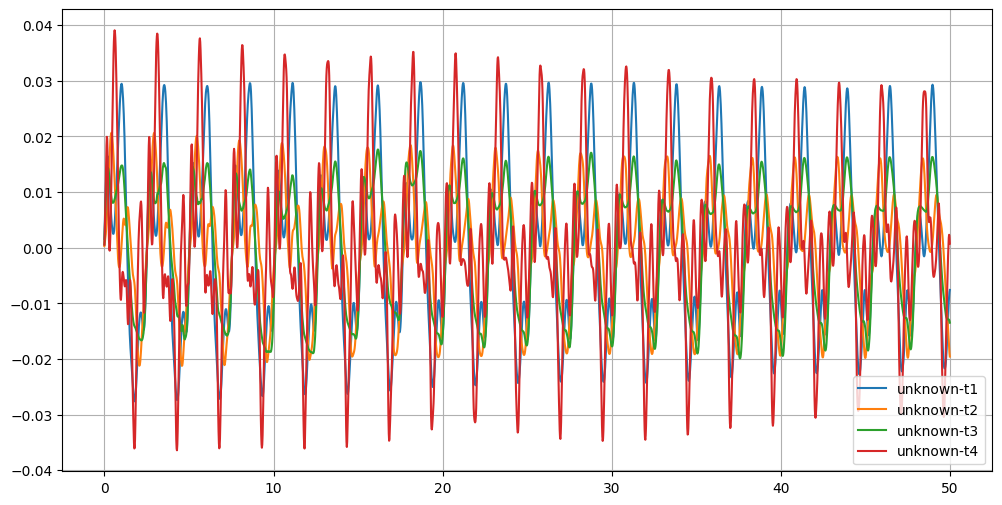

In [53]:
big_scary_plot(UNKNOWN_SAMPLES)

In [54]:
unknown_freqs = get_all_freqs(UNKNOWN_SAMPLES)

# of crests before linting for unknown-t1: 25
# of crests after linting for unknown-t1: 20
Avg period of unknown-t1: 0.002523121888588286
Frequency of unknown-t1: 396.3344000632133
---
# of crests before linting for unknown-t2: 40
# of crests after linting for unknown-t2: 20
Avg period of unknown-t2: 0.002524218421351687
Frequency of unknown-t2: 396.1622304715266
---
# of crests before linting for unknown-t3: 20
# of crests after linting for unknown-t3: 20
Avg period of unknown-t3: 0.0025220253558248837
Frequency of unknown-t3: 396.50671936758863
---
# of crests before linting for unknown-t4: 70
# of crests after linting for unknown-t4: 20
Avg period of unknown-t4: 0.002519832290298079
Frequency of unknown-t4: 396.8518078961941
---


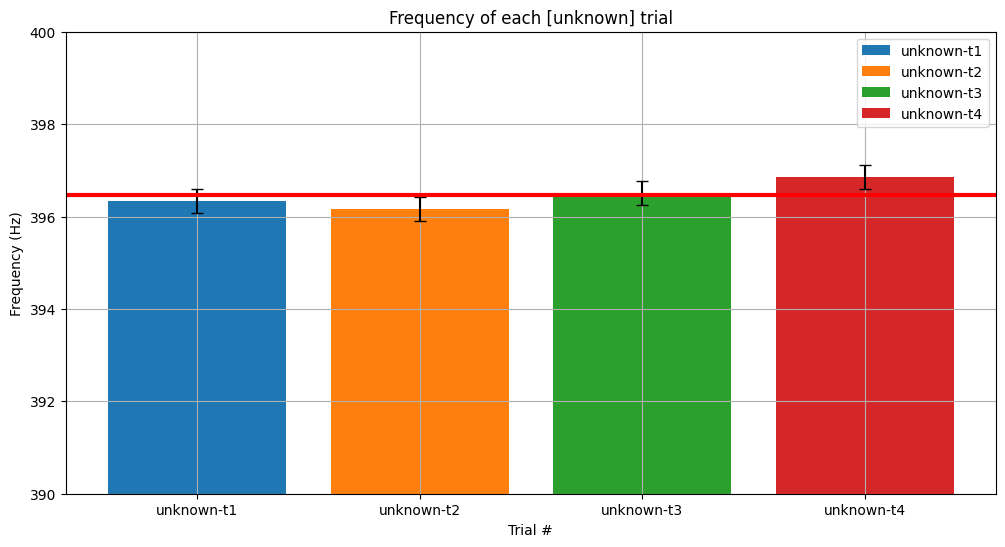

In [55]:
plot_freqs(unknown_freqs, UNKNOWN_SAMPLES, material='[unknown]', ylim_b=390, ylim_t=400)

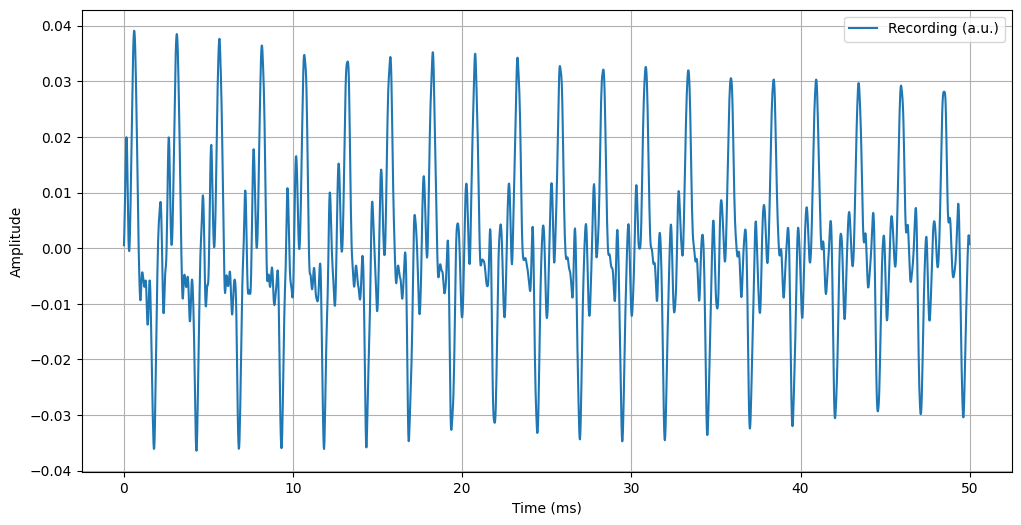

In [56]:
plot_trial_dataframe(unknown_t4)

In [57]:
UNKNOWN_FREQLIST = list(unknown_freqs.values())
val = UNKNOWN_FREQLIST[0] - UNKNOWN_FREQLIST[-1]
print('firstminuslast:', val)
UNKNOWN_AVG = np.average(UNKNOWN_FREQLIST)
UNKNOWN_AVG

firstminuslast: -0.5174078329807799


396.4637894496306